In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Data Prep

In [39]:
#Read in Data

df = pd.read_csv('risk_factors_cervical_cancer.csv')

In [40]:
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [41]:
#Replace '?' with NaN

df = df.replace('?',np.NaN)
df.columns = [x.lower() for x in df.columns]

#Convert all columns to numeric

for column in df.columns:
    df[column] = pd.to_numeric(df[column],errors='coerce')

In [42]:
#Evaluate which columns have null values

pd.isnull(df).sum() > 0

age                                   False
number of sexual partners              True
first sexual intercourse               True
num of pregnancies                     True
smokes                                 True
smokes (years)                         True
smokes (packs/year)                    True
hormonal contraceptives                True
hormonal contraceptives (years)        True
iud                                    True
iud (years)                            True
stds                                   True
stds (number)                          True
stds:condylomatosis                    True
stds:cervical condylomatosis           True
stds:vaginal condylomatosis            True
stds:vulvo-perineal condylomatosis     True
stds:syphilis                          True
stds:pelvic inflammatory disease       True
stds:genital herpes                    True
stds:molluscum contagiosum             True
stds:aids                              True
stds:hiv                        

In [43]:
#Evaluate how many null values per column

df.isnull().sum()

age                                     0
number of sexual partners              26
first sexual intercourse                7
num of pregnancies                     56
smokes                                 13
smokes (years)                         13
smokes (packs/year)                    13
hormonal contraceptives               108
hormonal contraceptives (years)       108
iud                                   117
iud (years)                           117
stds                                  105
stds (number)                         105
stds:condylomatosis                   105
stds:cervical condylomatosis          105
stds:vaginal condylomatosis           105
stds:vulvo-perineal condylomatosis    105
stds:syphilis                         105
stds:pelvic inflammatory disease      105
stds:genital herpes                   105
stds:molluscum contagiosum            105
stds:aids                             105
stds:hiv                              105
stds:hepatitis b                  

In [44]:
#Drop columns with significant proportion of NaN values, filter out remaining rows with NaN values

df = df.drop('stds: time since first diagnosis',axis=1)
df = df.drop('stds: time since last diagnosis',axis=1)
df = df.drop('stds:cervical condylomatosis',axis=1)
df = df.drop('stds:aids',axis=1)
df = df.dropna()

In [45]:
for column in df:
    print (column)

age
number of sexual partners
first sexual intercourse
num of pregnancies
smokes
smokes (years)
smokes (packs/year)
hormonal contraceptives
hormonal contraceptives (years)
iud
iud (years)
stds
stds (number)
stds:condylomatosis
stds:vaginal condylomatosis
stds:vulvo-perineal condylomatosis
stds:syphilis
stds:pelvic inflammatory disease
stds:genital herpes
stds:molluscum contagiosum
stds:hiv
stds:hepatitis b
stds:hpv
stds: number of diagnosis
dx:cancer
dx:cin
dx:hpv
dx
hinselmann
schiller
citology
biopsy


## Feature Exploration

In [46]:
df['cancer_risk'] = df['hinselmann']+df['schiller']+df['citology']+df['biopsy']

In [48]:
df2 = df[['iud','smokes','cancer_risk','age','num of pregnancies','number of sexual partners', 'first sexual intercourse']]

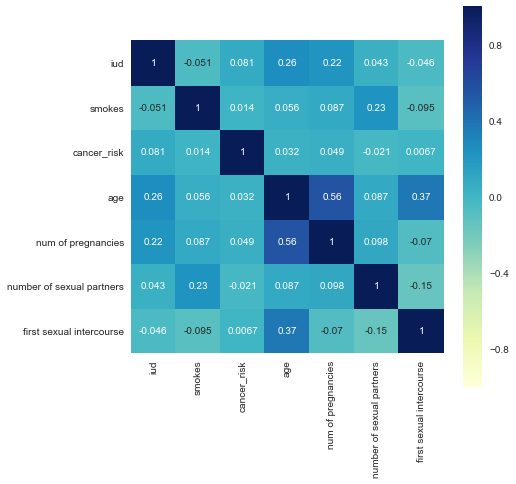

In [49]:
# Creating a heat map of Pear R values to see how other variables relate to cancer risk. May be useful in initial pass-through for filtering features.

correlation = df2.corr()
plt.figure(figsize=(7,7))
sns.heatmap(correlation,vmax=1,square=True,annot=True,cmap="YlGnBu")

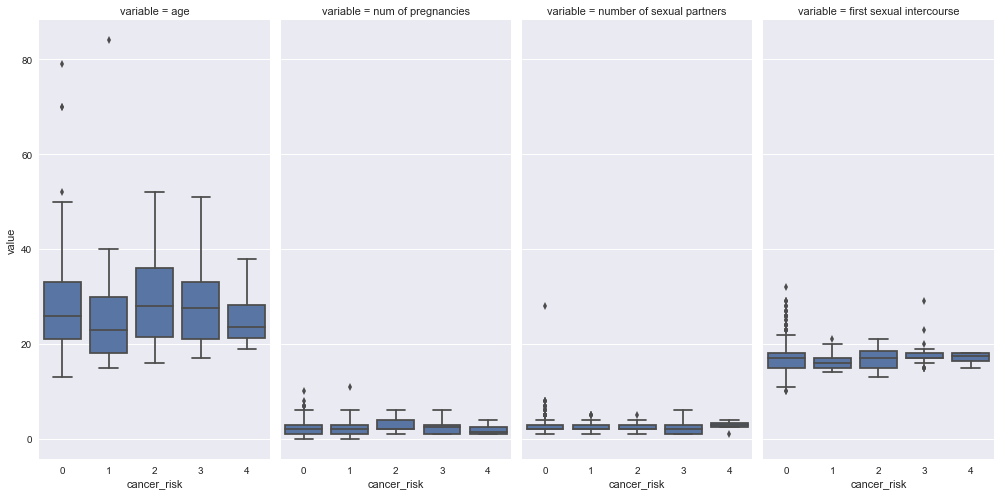

In [52]:
df3 = df2[['cancer_risk','age','num of pregnancies','number of sexual partners', 'first sexual intercourse']]
df3 = pd.melt(df3, id_vars=['cancer_risk'])

g = sns.FacetGrid(df3, col="variable", size=7,aspect=.5)
g = g.map(sns.boxplot,"cancer_risk","value")
plt.show()

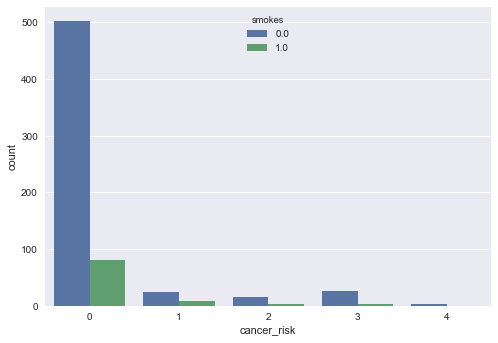

In [53]:
sns.set(style='darkgrid')
ax = sns.countplot(x='cancer_risk',hue='smokes',data=df2)

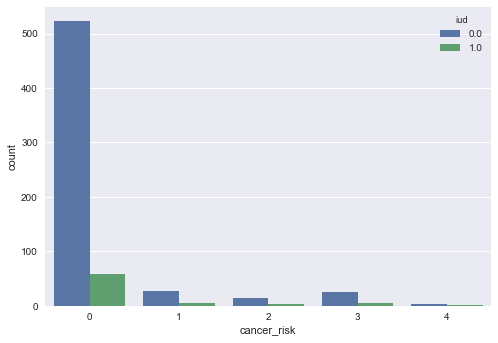

In [54]:
ax = sns.countplot(x='cancer_risk',hue='iud',data=df2)

## Feature Engineering

In [55]:
#Binning age groups into different risk levels based on literature
bins = [0,20,55,90]
group_names = [1,3,2]
categories = pd.cut(df['age'],bins,labels=group_names)
df2['age_group_risk'] = pd.cut(df2['age'],bins,labels=group_names)

#Multiple sexual partners is a risk factor, creating new feature to flag
df2['multiple_sexual_partners'] = np.where(df2['number of sexual partners'] > 1,1,0)

# Sexual intercourse at 17-years or younger is a risk factor, creating new feature to flag
df2['early_sexual_intercourse'] = np.where(df2['first sexual intercourse'] < 18,1,0)

# Having multiple children is a risk factor, creating new feature to flag
df2['multiple_children'] = np.where(df2['num of pregnancies'] > 1,1,0)

/Users/fnkyazn/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/fnkyazn/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/fnkyazn/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

# Feature Selection

### PCA

Keeping four components seems sensible as additional components add little value. 

[ 0.85839684  0.08176301  0.02808515  0.01410862  0.00648081]


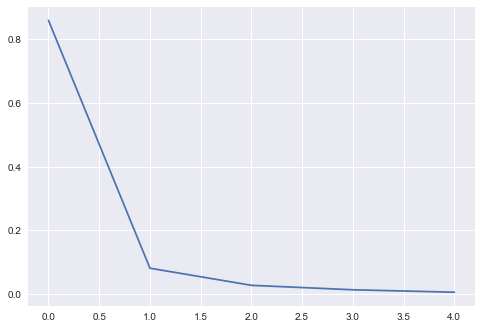

In [57]:
from sklearn import preprocessing

pca = PCA(n_components=5)

df_scaled = StandardScaler().fit_transform(df)

pca.fit_transform(df2)

plt.plot(pca.explained_variance_ratio_)

print(pca.explained_variance_ratio_)



In [58]:
print(pca.explained_variance_ratio_)

[ 0.85839684  0.08176301  0.02808515  0.01410862  0.00648081]
